# Projeto - Séries Temporais
## Residência em Ciência de Dados - SAMSUNG/UFPE

### Alunos:
- Lucas Couri (lncc2)
- Mariama Oliveira (mcso)

# Bibliotecas

In [1]:
#import statsmodels.api as sm
import statsmodels.tsa.api as tsa
#from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
# import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=Warning)
#import matplotlib as mpl
#import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor

#mpl.rcParams['figure.figsize'] = [10, 5]

results = {}

Utilizamos o dataset disponível no Kaggle sobre as temperaturas médias em Delhi (https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data). O dataset já era dividido em train e test, portanto, juntamos os dois datasets para depois separar em train e test da forma desejada.

In [2]:
#https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data
df = pd.read_csv("temp_delhi.csv")

In [3]:
df = df[["date", "meantemp"]]
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index(df['date'], inplace=True) 
df = df.drop('date', 1)


In [ ]:
df.shape

In [ ]:
df.tail()

Separando dados em treino, teste e validação. Vale notar que para os modelos lineares utilizaremos apenas treino (75%) e teste (25%), enquanto que para os modelos de machine learning utilizaremos treino (50%), validação (25%) e teste (25%).

In [ ]:
df_train = df.iloc[:int(len(df) * 0.75)]
df_test = df.iloc[int(len(df) * 0.75):]

#df_train2 = df.iloc[:int(len(df) * 0.5)]
#df_valid2 = df.iloc[int(len(df) * 0.5):int(len(df) * 0.75)]
#df_test2 = df.iloc[int(len(df) * 0.75):]

#### Funções de apoio

Algumas funções construídas para exibir e salvar as métricas de cada modelo e plotar os gráficos de ajuste e predição.

In [4]:
def show_metrics(y_test,prediction, results, name):
    print(f'{name} - model Results')
    print('r2' , r2_score(prediction, y_test))
    print('mse' ,mean_squared_error(prediction, y_test))
    print('mae', mean_absolute_error(prediction, y_test))
    print('mape', mean_absolute_percentage_error(prediction, y_test))
    metrics = {'r2':r2_score(prediction, y_test), \
                    'mse': mean_squared_error(prediction, y_test), 
                    'mae': mean_absolute_error(prediction, y_test),
                    'mape': mean_absolute_percentage_error(prediction, y_test)}
    results[name] = metrics
    return metrics
    

def graf_ajuste(pred, train, titulo):
    #Previsão do treino
    fig, ax = plt.subplots()
    ax.plot(pred, label='pred')
    ax.plot(train, label='true')
    plt.title(titulo)
    plt.legend()

def graf_pred(fc, train, test, titulo, SVR=False):
    
    fc_series = pd.Series(fc, index=test.index[1:])

    #if(SVR==True):
    #    fc = fitted
    #    fc_series = pd.Series(fc, index=test.index[1:])
    #else:
        #fitted2 = fitted.apply(test)
        #fc = fitted2.predict(start='2016-03-28', end='2017-04-24')  # 95% conf
        #fc_series = pd.Series(fc, index=test.index)

    # Plot
    #plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(fc_series, label='Predição')
    plt.title(titulo)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

## Plot

Plotando a série temporal da temperatura média de Delhi

In [ ]:
df.plot()
plt.title("Temperatura Média - Delhi")
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

## Decomposição

Através da decomposição verificamos que há tendência e sazonalidade, portanto a série não deve ser estacionária, vamos verificar a seguir.

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
df_decomp = tsa.seasonal_decompose(df, period=365)
df_decomp.plot()

## Autocorrelação e Estacionariedade

Como a função de auto correlação abaixo não decai  para zero, suspeitamos de que a série não seja estacionária. Vamos verificar a seguir por meio de um teste de hipótese.

In [ ]:
plot_acf(df)

In [ ]:
plot_pacf(df)

Considerando um nível de confiança de 0,05 verificamos que o teste de Dickey-Fuller nos leva a não rejeitar a hipótese nula de não estacionariedade, visto que o p-valor = 0,149 (>0,05). Portanto, temos evidências que a série não é estacionária.

In [ ]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df)
print(pvalue)
print(lags)

## Diferenciação

In [ ]:
df.diff().plot()
plt.title("Série diferenciada")
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

Após diferenciar a série aparenta ser estacionária, vamos verificar com o teste de Dickey-Fuller.

In [ ]:
df.diff().plot.hist()
plt.title("Histograma da série diferenciada")
plt.ylabel("Frequência")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

In [ ]:
dfd1 = df.diff().dropna()

Como o p-valor<0,05 então decidimos rejeitar a hipótese nula de não estacionariedade à um nível de confiança de 0,05. Portanto, após diferenciar uma vez a série temos evidências para acreditar que a série se tornou estacionária.

In [ ]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(dfd1)
print(pvalue)
print(lags)

## Autocorrelação da série diferenciada

### Correlação

Correlação com série diferenciada

In [ ]:
dfd1.corrwith(dfd1.shift(1))

In [ ]:
plot_acf(dfd1)

Verificamos a partir do comportamento da função de autocorrelação acima que os lags são significantes até o lag 3, e a partir dele se tornam não significativos. 

## Autocorrelação Parcial

Correlação Parcial com série diferenciada

In [ ]:
plot_pacf(dfd1)

Verificamos a partir da função de autocorrelação parcial acima que a partir do lag5 os lags se tornam não significativos. Analisando de forma mais conservadora é possível argumentar que o lag5 está bem próximo do limite.

### ARIMA

In [ ]:
df_train.index = pd.DatetimeIndex(df_train.index.values, freq=df_train.index.inferred_freq)
#df_train.head()

Função para realizar o ajuste dos modelos ARIMA

In [ ]:
def perform_arima(p,d,q,data):
    arima_model = ARIMA(data, order=(p,d,q))
    res_arima = arima_model.fit()
    print(res_arima.summary())
    res_arima.plot_diagnostics()
    return res_arima


#### ARIMA (5,1,3)

A partir da analise dos gráficos da função de autocorrelação e autocorrelação parcial decidimos ajustar um ARIMA (5,1,3) visto que a série se torna estacionária após uma diferenciação, há decaimento após lag 3 do gráfico de autocorrelação e também há um corte após o lag 5 do gráfico de autocorrelação parcial.

In [ ]:
res_arima_1 = perform_arima(5,1,3,df_train)

In [ ]:
res_arima_1_test = res_arima_1.apply(df_test)
fc = res_arima_1_test.predict(start='2016-03-28', end='2017-04-24')
graf_pred(fc, df_train, df_test, 'Delhi - ARIMA (5,1,3) - Predição')

In [ ]:
show_metrics(df_test[1:], fc, results, 'ARIMA(5,1,3)')

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

#### ARIMA (4,1,3)

Também decidimos testar o ARIMA (4,1,3) visto que, com um olhar mais conservador, o corte na função de autocorrelação parcial pode ser visto como no lag 4.

In [ ]:
res_arima_2 = perform_arima(4,1,3,df_train)

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

In [ ]:
graf_ajuste(res_arima_2.predict(), df_train, 'Delhi - ARIMA (4,1,3) - Treino')

In [ ]:
res_arima_2_test = res_arima_2.apply(df_test)
fc = res_arima_2_test.predict(start='2016-03-28', end='2017-04-24')
graf_pred(fc, df_train, df_test, 'Delhi - ARIMA (4,1,3) - Predição')

In [ ]:
show_metrics(df_test[1:], fc, results, 'ARIMA(4,1,3)')

#### ARIMA (0,1,3)

Como o comportamento da funções de autocorrelação e autocorrelação parcial em algumas partes não foi tão claro, sem um decaímento exponencial muito evidente, decidimos também avaliar a hipótese de que há o corte brusco na função de autocorrelação, configurando um MA(3), dessa forma avaliamos o modelo ARIMA(0,1,3).

In [ ]:
res_arima_3 = perform_arima(0,1,3,df_train)

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

In [ ]:
res_arima_3_test = res_arima_3.apply(df_test)
fc = res_arima_3_test.predict(start='2016-03-28', end='2017-04-24')
graf_pred(fc, df_train, df_test, 'Delhi - ARIMA (0,1,3) - Predição')

In [ ]:
show_metrics(df_test[1:], fc, results, 'ARIMA(0,1,3)')

### Auto ARIMA

In [ ]:
auto_arima = pm.auto_arima(df_train, max_ar=10, max_ma=5, max_d=2, seasonal=False, trace=True, stepwise=True) #verificar forcar estacionario

O Auto ARIMA nos informa que, dentre os modelos testados, o ARIMA (2,0,1) é o modelo com o menor AIC (Critério de Informação de Akaike)

In [ ]:
auto_arima.summary()

In [ ]:
auto_arima.plot_diagnostics()

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

Plotando ajuste do modelo aos dados de treino

In [ ]:
graf_ajuste(auto_arima.predict_in_sample(), df_train.values, 'Delhi - Auto ARIMA(2,0,1) - Treino')

Plotando Treino, teste e predição

In [ ]:
auto_model = ARIMA(df_train, order=(2, 0, 1))  
res_arima_4 = auto_model.fit()
res_arima_4_test = res_arima_4.apply(df_test)
fc = res_arima_4_test.predict(start='2016-03-28', end='2017-04-24')
graf_pred(fc, df_train, df_test, 'Delhi - ARIMA (2,0,1) - Predição')

In [ ]:
show_metrics(df_test[1:], fc, results, 'ARIMA(2,0,1)')

## Machine Learning

Foram gerados modelos utilizando três métodos de ML (KNN, SVR e MLP). Espera-se que com estes métodos seja possível capturar também relações não lineares existentes na série.

### Feature Engineering

Primeiramente, foi necessário realizar feature engineering no dados da série a fim de criar features relevantes para os modelos.

Foi utilizada a função **get_lags**, a qual cria features que correspodem a atrasos da série temporal. O número de atrasos  pode ser determinado a partir da análise do correlograma utilizando a quantidade de lags correlacionados.

In [7]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

Decidimos utilizar o número de lags 5, assim foram criadas 5 novas features com os atrasos para a série.

In [8]:
X = get_lags(df, 3)
X.head()

,meantemp-1,meantemp-2,meantemp-3
date,,,
2013-01-04,7.166667,7.400000,10.000000
2013-01-05,8.666667,7.166667,7.400000
2013-01-06,6.000000,8.666667,7.166667
2013-01-07,7.000000,6.000000,8.666667
2013-01-08,7.000000,7.000000,6.000000


In [10]:
y = df.reindex(X.index)
y.head()

,meantemp
date,
2013-01-04,8.666667
2013-01-05,6.000000
2013-01-06,7.000000
2013-01-07,7.000000
2013-01-08,8.857143


### Separando os dados

Os dados foram separados em treino e teste, para serem utilizado no GridSearch. Como o ScikitLearn separa os dados de validação, o conjunto de teste abaixo já contém o conjunto de validação.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)

### KNN

Utilizamos o GridSearch para encontrar os melhores parâmetros para o KNN. Foram utilizados dois hiperâmetros: o número de vizinhos(n_neighbors) e o peso (weights). 

In [ ]:
#Definindo hiperpâmetros de busca do GridSearch
parameters = {'n_neighbors':range(1,20), 'weights':["uniform", "distance"]}
for p in parameters.items():
  print(p)

In [ ]:
knn = KNeighborsRegressor()
knnGS = GridSearchCV(knn, parameters, scoring='neg_mean_absolute_percentage_error', cv=TimeSeriesSplit(n_splits=2, test_size=round(len(df)*0.25)))
res = knnGS.fit(X_train, y_train)
print(res.best_score_)
print(res.best_params_)

Métricas

In [ ]:
prediction = res.predict(X_test)
show_metrics(y_test, prediction, results, 'KNN GS')

In [ ]:
graf_ajuste(prediction, y_test.reset_index(drop=True), 'Delhi Temperature - KNN GS MODEL')


In [ ]:
def graf_pred(fitted, train, test, titulo, SVR=False):
    
    if(SVR==True):
        fc = fitted
        fc_series = pd.Series(fc, index=test.index[1:])
    else:
        fc = fitted.forecast(394, alpha=0.05)  # 95% conf
        fc_series = pd.Series(fc, index=test.index)

    # Plot
    #plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(fc_series, label='Predição')
    plt.title(titulo)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [ ]:
residuos = prediction.flatten() - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

In [ ]:
pd.Series(residuos).plot.kde()

In [ ]:
plot_acf(residuos)

Acima verificamos que o modelo se ajustou bem aos valores reais de acordo com as métricas. No entanto, abaixo foi feito o KNN com a série diferenciada a fim de verificar se há possibilidade de conseguir melhores valores. 

#### KNN com série difenciada

In [ ]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

In [ ]:
res_diff = knnGS.fit(X_train_d1, y_train_d1)
print(res_diff.best_score_)
print(res_diff.best_params_)

In [ ]:
prediction_diff = res_diff.predict(X_test_d1)
show_metrics(y_test_d1, prediction_diff, results, 'd1 KNN GS')

In [ ]:
graf_ajuste(pd.Series(prediction_diff.flatten()), y_test_d1.reset_index(drop=True), 'Delhi - KNN diff')

One step 


In [ ]:
graf_ajuste(pd.Series(prediction_diff.flatten()).cumsum(), y_test_d1.reset_index(drop=True).cumsum(), 'Delhi - KNN')

Como o gráfico apresentou pouco ajuste ao valor real, decidimos utilizar o valor real para ajustar a predição. 

In [ ]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(prediction_diff.flatten(), name='temperature'),axis=0)
graf_ajuste(pred_one, y_test.reset_index(drop=True), 'Delhi Temperature - KNN')

In [ ]:
show_metrics(y_test.iloc[1:-1], pred_one.iloc[1:-1], results, 'pred one KNN GS')

In [ ]:
residuos = prediction_diff.flatten() - y_test_d1.reset_index(drop=True).values.flatten()

In [ ]:
pd.Series(residuos).plot()

In [ ]:
pd.Series(residuos).plot.kde()

In [ ]:
plot_acf(residuos)

Ao final do experimento com o KNN, verificamos que foi possível obter melhores resultados com a série diferenciada. No entanto, foi necessário a utilização de valores reais para o ajuste da tendência da série.

### Support Vector Regression

Aqui utilizaremos o Support Vector Regression, primeiro vamos ajustar um modelo simples e depois tentar melhorar os parâmetros com o uso do GridSearch.

In [ ]:
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2, kernel='linear')

regr.fit(X_train, y_train)

In [ ]:
forecast = regr.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR')

In [ ]:
graf_ajuste(regr.predict(X_test), y_test.reset_index(drop=True), 'Delhi - SVR')

In [ ]:
graf_pred(regr.predict(X_test), df_train, df_test, 'Delhi - SVR', SVR=True)

Verificamos que o modelo ajustou muito bem aos dados e fez predições do conjunto de teste muito próximas dos valores reais, como podemos verificar nos gráficos acima e nas métricas de avaliação.

#### Grid Search

Agora vamos utilizar o GridSearch para explorar diferentes parâmetros e do SVR e encontrar os melhores.

In [ ]:
parameters = {'kernel':['linear','rbf', 'sigmoid', 'polynomial'], 
              'C':np.linspace(0.05, 10, 20),
              'gamma':np.linspace(.1, 10, 3),
              'coef0':np.linspace(.01, 10, 3),
              'degree':np.arange(2, 3)
              }

for p in parameters.items():
  print(p)

In [ ]:
regr2 = SVR()
regrGS = GridSearchCV(regr2, parameters, scoring='neg_mean_absolute_percentage_error', cv=TimeSeriesSplit(n_splits=2, test_size=round(len(df)*0.25)))

In [ ]:
res = regrGS.fit(X_train, y_train)

Após executar o GridSearch obtivemos como melhor score e parâmetros:

In [ ]:
print(res.best_score_)
print(res.best_params_)
#{'C': 7.38157894736842, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}
#18 min

In [ ]:
regr2 = SVR(C=10, kernel='linear')
res = regr2.fit(X_train, y_train)

In [ ]:
forecast = regr2.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR GS')

In [ ]:
graf_ajuste(res.predict(X_test), y_test.reset_index(drop=True), 'Delhi Temperature - SVR GS MODEL')

In [ ]:
graf_pred(res.predict(X_test), df_train, df_test, 'Delhi - SVR GS', SVR=True)

In [ ]:
residuos = res.predict(X_test).flatten() - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

In [ ]:
pd.Series(residuos).plot.kde()

In [ ]:
plot_acf(residuos)

Verificando Overfitting

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    SVR(kernel='linear'), X, y, train_sizes=[50,100,150,200,250], cv=TimeSeriesSplit())
    #SVR(kernel='linear'), X, y, train_sizes=[np.round(np.array(list(range(0.1,1,0.1))) * len(y))], cv=TimeSeriesSplit())

In [ ]:
pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
plt.legend()

A partir do gráfico acima não aparenta haver Overfit.

#### SVR com Serie diferenciada

In [ ]:
regr2 = SVR(C=10, kernel='linear')
res = regr2.fit(X_train_d1, y_train_d1)

In [ ]:
forecast_diff = regr2.predict(X_test_d1)
show_metrics(y_test_d1, forecast_diff, results, 'SVR d1')

In [ ]:
graf_ajuste(pd.Series(forecast_diff.flatten()), y_test_d1.reset_index(drop=True), 'Delhi - SVR diff')

In [ ]:
graf_ajuste(pd.Series(forecast_diff.flatten()).cumsum(), y_test_d1.reset_index(drop=True).cumsum(), 'Delhi - KNN')

In [ ]:
pred_one_svr = y_test.shift(1).reset_index(drop=True).add(pd.Series(forecast_diff.flatten(), name='temperature'),axis=0)
graf_ajuste(pred_one_svr, y_test.reset_index(drop=True), 'Delhi Temperature - KNN')

In [ ]:
show_metrics(y_test.iloc[1:-1], pred_one_svr.iloc[1:-1], results, 'pred one SVR diff')

In [ ]:
residuos = forecast_diff.flatten() - y_test_d1.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

In [ ]:
pd.Series(residuos).plot.kde()


In [ ]:
plot_acf(residuos)

In [ ]:
pd.DataFrame(results)

### MLP

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

#### Divisão de Dados MLP 

Antes de tudo, foi realizada a divisão dos dados de treino, teste e validação. Diferentemente dos outros algoritmos de ML, a divisão teve que ser explícita, pois a biblioteca utilizada não divide automaticamente os dados.

In [42]:
#Separando os dados - 50% treino, 25% validaçao, 25% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle=False, test_size=.333)


In [12]:
X_valid.shape

(393, 3)

#### Diferenciação

Abaixo é realizada a diferenciação da série, pois realizamos o experimento com ela diferenciada e não diferenciada, a fim de entender se há diferenças na performance do modelo.

In [43]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_valid_d1 = X_valid.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_valid_d1 = y_valid.diff().dropna()
y_test_d1 = y_test.diff().dropna()

#### Normalização

A normalização dos valores da série são essenciais para a boa performance do modelo, pois ela possíbilita que a busca pelas regiões que minizam o erro do modelo seja feita de maneira mais eficiente.

In [14]:
X_train_norm = X_train.sub(X_train.mean()).div(X_train.std())
X_valid_norm = X_valid.sub(X_valid.mean()).div(X_valid.std())
X_test_norm = X_test.sub(X_train.mean()).div(X_train.std())

In [44]:
#Valores diferenciados
X_train_d1_norm = X_train_d1.sub(X_train_d1.mean()).div(X_train_d1.std())
X_valid_d1_norm = X_valid_d1.sub(X_valid_d1.mean()).div(X_valid_d1.std())
X_test_d1_norm = X_test_d1.sub(X_train_d1.mean()).div(X_train_d1.std())

<AxesSubplot:xlabel='date'>

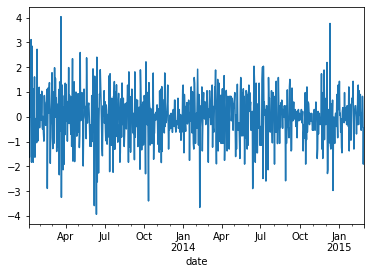

In [17]:
X_train_d1_norm['meantemp-1'].plot()

#### Batches

Abaixo são feita a definição dos batches que alimentam o modelo.

In [18]:
training_data = torch.tensor(pd.concat([X_train_norm, y_train], axis=1).values)
validating_data = torch.tensor(pd.concat([X_valid_norm, y_valid], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_norm, y_test], axis=1).values)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(validating_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

In [100]:
training_data = torch.tensor(pd.concat([X_train_d1_norm, y_train_d1], axis=1).values)
validating_data = torch.tensor(pd.concat([X_valid_d1_norm, y_valid_d1], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_d1_norm, y_test_d1], axis=1).values)

train_dataloader_d1 = DataLoader(training_data, batch_size=16, shuffle=False)
valid_dataloader_d1 = DataLoader(validating_data, batch_size=16, shuffle=False)
test_dataloader_d1 = DataLoader(testing_data, batch_size=16, shuffle=False)

#### Modelo MLP

A classe MLP abaixo define como será a arquitetura da MLP. Durante o experimento, foram testadas diferentes configuração com a intenção de entender o impacto na performance do modelo.

In [119]:
n_lags = 3

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Config 1
    # self.fc1 = nn.Linear(n_lags,100)
    # self.fc3 = nn.Linear(100,1)
    
    #Config 2
    # self.fc1 = nn.Linear(n_lags,32)
    # self.fc2 = nn.Linear(32,64)
    # self.fc3 = nn.Linear(64,1)
     
    # #Config 3
    self.config3 = nn.Sequential(
            nn.Linear(n_lags,32),
            # nn.BatchNorm1d(32), 
            nn.ReLU(),
            nn.Linear(32, 64),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
    )
  
  def forward(self, X):
    out = self.config3(X)
    return out

#### Funções de treinamento

Abaixo estão as funções que possibilitam que o treinamento do MLP seja realizada diversas vezes, uma vez que serão gerados 10 modelo diferentes.

In [153]:
def train_mlp(model, train_dataloader, valid_dataloader):

  epochs = 300
  loss_fn = nn.MSELoss()
  #optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
  optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 0.005)
  
  history_train = {}
  history_valid = {}
  
  for epoch in range(1, epochs+1):
    loss_train = 0.0
    for train_data in train_dataloader:
      x = train_data[:,:n_lags].float()
      y = train_data[:,n_lags].float()
      # print("X: ",x)
      # print("y: ",y)
    
      #forward pass
      outputs = model(x)
      # print("outputs: ", outputs)

      #loss measure
      loss = loss_fn(outputs,y)
      # print("Loss: ", loss)

      #backward pass
      optimizer.zero_grad() # pára o autograd
      loss.backward() # executa o backpropagation
      optimizer.step() # atualiza os pesos

      loss_train += loss.item() # soma os erros para obter o erro total

    loss_valid = 0.0
    for valid_data in valid_dataloader:    
      x = valid_data[:,:n_lags].float()
      y = valid_data[:,n_lags].float()   
      #forward pass
      target = model(x)
      #loss measure
      loss = loss_fn(outputs,y)
      # Calculate Loss
      loss_valid += loss.item()


    if (epoch % 10 == 0):
      print('Epoch{}, train loss {}'.format(epoch, loss_train / len(train_dataloader)))
      print('Epoch{}, valid loss {}'.format(epoch, loss_valid / len(valid_dataloader))) # apresenta o erro médio da época
    history_train[epoch] = loss_train / len(train_dataloader)
    history_valid[epoch] = loss_valid / len(valid_dataloader)

  # pd.Series(history_train).plot()
  # pd.Series(history_valid).plot()
  
  return model


def predict_mlp(model, test_dataloader):
    model.eval()
    results_MLP = []
    for test_data in test_dataloader:
        x = test_data[:,:n_lags].float()
        y = test_data[:,n_lags].float()
        
        y_pred = model(x)
        results_MLP.extend(y_pred.flatten().detach().numpy())
        
    return results_MLP
#pd.DataFrame(results).plot()
# results_MLP[:10]


def get_best_model(metric_name, all_metrics, arr_models):    
    model_metrics = min(all_metrics.keys(), key=(lambda new_k: all_metrics[new_k][metric_name]))
    index_best = model_metrics[-1] 
    return arr_models[int(index_best)]
  
  
def generate_models(train_dataloader, valid_dataloader, y_test, test_dataloader):
    mlp_models = []
    results_metrics_MLP = {}

    for i in range(10):
        print(f"Modelo {i}")
        multi_neuron = MLP()
        
        train_mlp(multi_neuron, train_dataloader, valid_dataloader)
        mlp_models.append(multi_neuron)
        results_MLP = predict_mlp(multi_neuron, test_dataloader)
        
        show_metrics(y_test,results_MLP, results_metrics_MLP, f'MLP{i}')
        
    return mlp_models, results_metrics_MLP

#### Treinando MLP

Esta função é responsável pelo pipeline da experimento da MLP, nela serão executadas 10 vezes o treinamento e teste dos modelos.

In [111]:
mlp_models, results_metrics_MLP = generate_models(train_dataloader, valid_dataloader, y_test, test_dataloader)

Modelo 0
Epoch10, train loss 17.23599435210228
Epoch10, valid loss 99.17112963676453
Epoch20, train loss 17.897266688346864
Epoch20, valid loss 95.46045413970947
Epoch30, train loss 18.523538296222686
Epoch30, valid loss 89.93712965011596
Epoch40, train loss 20.081370613574983
Epoch40, valid loss 89.4074863243103
Epoch50, train loss 20.48174132823944
Epoch50, valid loss 82.44524808883666
Epoch60, train loss 21.40625650167465
Epoch60, valid loss 79.60527378082276
Epoch70, train loss 22.483389649391174
Epoch70, valid loss 74.2244485282898
Epoch80, train loss 23.025656287670135
Epoch80, valid loss 68.90154123306274
Epoch90, train loss 23.90421047925949
Epoch90, valid loss 64.80440177917481
Epoch100, train loss 24.03084638595581
Epoch100, valid loss 60.56732194900513
Epoch110, train loss 25.05059030532837
Epoch110, valid loss 63.86535224914551
Epoch120, train loss 27.437176322937013
Epoch120, valid loss 75.08838306427002
Epoch130, train loss 28.262382018566132
Epoch130, valid loss 64.20195

In [112]:
pd.DataFrame(results_metrics_MLP)

,MLP0,MLP1,MLP2,MLP3,MLP4,MLP5,MLP6,MLP7,MLP8,MLP9
r2,0.510567,-0.142878,0.104356,-0.287565,-0.362309,-0.454054,-0.297583,-0.081574,-4.465433,0.328615
mse,37.858623,79.411572,223.110059,580.913827,1621.812300,2304.969057,1002.497632,285.751855,191.086139,121.458602
mae,5.068069,6.195903,11.407306,19.067812,30.164790,36.562148,23.641744,12.761703,11.951478,8.412436
mape,0.277837,0.230231,0.366513,0.388607,0.449970,0.605566,0.431431,0.376394,0.771122,0.305462


Abaixo é escolhido melhor modelo e apresentado seus resultados.

In [113]:
best_MLP = get_best_model("mse", results_metrics_MLP, mlp_models)
pred_best_MLP = predict_mlp(best_MLP, test_dataloader)

In [114]:
show_metrics(y_test,pred_best_MLP, results, 'MLP')

MLP - model Results
r2 0.5105674883439049
mse 37.85862278437581
mae 5.068068572921388
mape 0.27783695109509216


{'r2': 0.5105674883439049,
 'mse': 37.85862278437581,
 'mae': 5.068068572921388,
 'mape': 0.27783695109509216}

<AxesSubplot:>

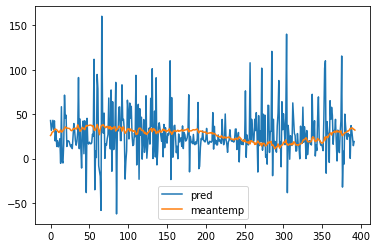

In [129]:
pd.concat([pd.Series(pred_best_MLP, name='pred'), y_test.reset_index(drop=True)],axis=1).plot()

Analise do resíduo

<AxesSubplot:>

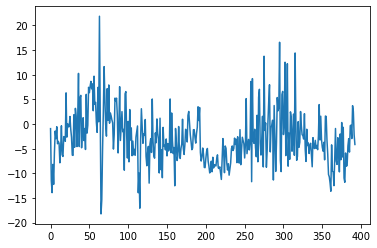

In [116]:
residuos = pred_best_MLP - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

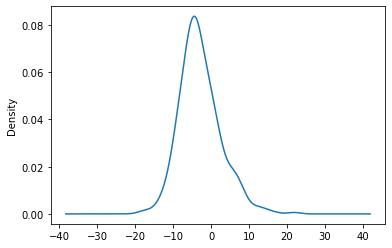

In [117]:
pd.Series(residuos).plot.kde()

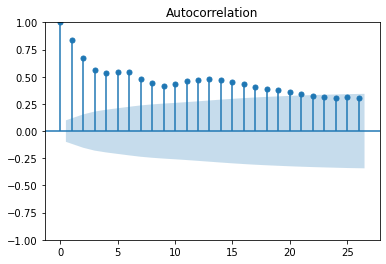

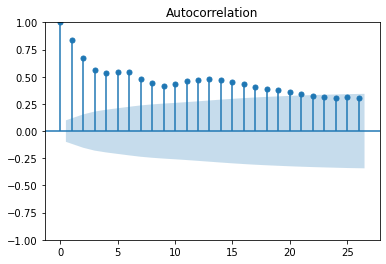

In [97]:
plot_acf(residuos)

#### Com dados diferenciados

O mesmo procedimento seguido acima foi realizado com os dados diferenciados.

In [145]:
mlp_models_d1, results_metrics_MLP_d1 = generate_models(train_dataloader_d1, valid_dataloader_d1, y_test_d1, test_dataloader_d1)

Modelo 0
Epoch10, train loss 2.7262976595759394
Epoch10, valid loss 2.9873182237148286
Epoch20, train loss 2.7206439024209974
Epoch20, valid loss 3.0187134885787965
Epoch30, train loss 2.7164350390434264
Epoch30, valid loss 3.0523137831687928
Epoch40, train loss 2.713265770971775
Epoch40, valid loss 3.0895972764492035
Epoch50, train loss 2.710348266661167
Epoch50, valid loss 3.127895772457123
Epoch60, train loss 2.708468684256077
Epoch60, valid loss 3.1509017086029054
Epoch70, train loss 2.7063591703772545
Epoch70, valid loss 3.187039308547974
Epoch80, train loss 2.704799258410931
Epoch80, valid loss 3.2157712602615356
Epoch90, train loss 2.7031557458639144
Epoch90, valid loss 3.2455772805213927
Epoch100, train loss 2.701724982857704
Epoch100, valid loss 3.278091325759888
Epoch110, train loss 2.7003493878245353
Epoch110, valid loss 3.3049708080291746
Epoch120, train loss 2.699560535252094
Epoch120, valid loss 3.32078542470932
Epoch130, train loss 2.698007118701935
Epoch130, valid loss 

In [146]:
pd.DataFrame(results_metrics_MLP_d1)

,MLP0,MLP1,MLP2,MLP3,MLP4,MLP5,MLP6,MLP7,MLP8,MLP9
r2,-186.621951,-192.586556,-195.286579,-199.729252,-181.019080,-200.169578,-184.714561,-224.066832,-189.979812,-188.505140
mse,2.750227,2.757111,2.759130,2.757396,2.768479,2.767216,2.769273,2.752321,2.749288,2.762064
mae,1.255934,1.256027,1.257226,1.256406,1.259007,1.258870,1.260872,1.256369,1.255514,1.257475
mape,235.762932,72.630538,117.234109,90.374786,122.323018,634.088803,56.861005,37.426076,310.758325,71.457265


Resultados do melhor modelo

In [154]:
best_MLP_d1 = get_best_model("mse", results_metrics_MLP_d1, mlp_models_d1)
pred_best_MLP_d1 = predict_mlp(best_MLP_d1, test_dataloader_d1)

In [155]:
show_metrics(y_test_d1,pred_best_MLP_d1, results, 'MLP-d1')

MLP-d1 - model Results
r2 -189.97981168315715
mse 2.749288407431234
mae 1.2555136957315844
mape 310.7583252780401


{'r2': -189.97981168315715,
 'mse': 2.749288407431234,
 'mae': 1.2555136957315844,
 'mape': 310.7583252780401}

<AxesSubplot:>

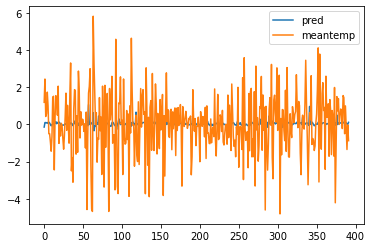

In [156]:
pd.concat([pd.Series(pred_best_MLP_d1, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

Analise do resíduo

<AxesSubplot:>

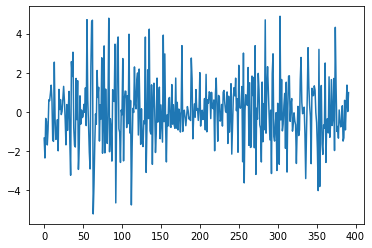

In [157]:
residuos = pred_best_MLP_d1 - y_test_d1.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

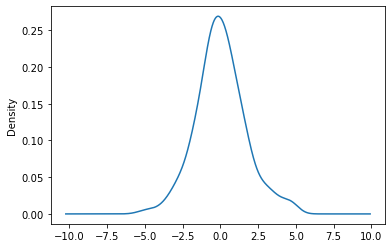

In [158]:
pd.Series(residuos).plot.kde()

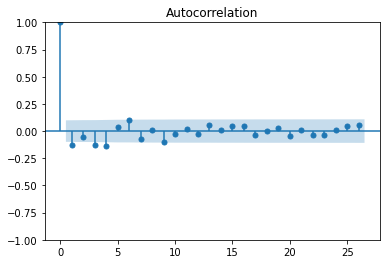

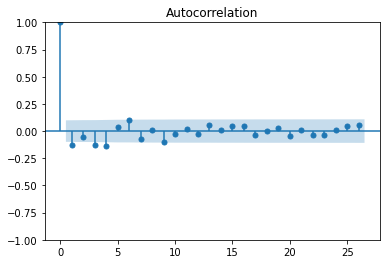

In [159]:
plot_acf(residuos)

## Resultado dos Modelos

In [125]:
pd.DataFrame(results)

,MLP,MLP-d1
r2,0.510567,-1.007073
mse,37.858623,1452.118525
mae,5.068069,29.918793
mape,0.277837,1.394796


In [ ]:
# graf_ajuste(pd.Series(pred_best_MLP).cumsum(), y_test_d1.reset_index(drop=True).cumsum(), 'Delhi Temperatue - MLP')

In [ ]:
# pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(pred_best_MLP, name='temperature'),axis=0)
# graf_ajuste(pred_one, y_test.reset_index(drop=True), 'Delhi Temperature - KNN')

In [ ]:
# pred_one = pred_one.fillna(method='bfill')
# show_metrics(y_test[:-1],pred_one[:-1] , results, 'MLP pred_one')